<a href="https://colab.research.google.com/github/1000century/likelion_proj2/blob/main/code/train/v12_occ_vet_q_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install evaluate -qq
! pip install datasets -qq
! pip install bert_score -qq
! pip install rouge-score -qq
! pip install --upgrade nltk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.6 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.


In [ ]:
import gc

In [ ]:
from datasets import load_dataset, Dataset, DatasetDict
import pandas as pd
import json
import os
import zipfile
from typing import List, Dict

def flatten_json_data(data_list):
    """JSON 데이터를 평탄화하는 함수"""
    return pd.json_normalize(
        data_list,
        sep='_',
        record_path=None,
        meta=[
            'category',
            'job_field',
            'gender',
            'experience',
            ['version'],
            ['dataSet', 'answer', 'raw', 'text'],
            ['dataSet', 'answer', 'summary', 'text'],
            ['dataSet', 'question', 'raw', 'text'],
            ['dataSet', 'info', 'ageRange'],
            ['dataSet', 'info', 'channel'],
            ['dataSet', 'info', 'date'],
            ['dataSet', 'info', 'experience'],
            ['dataSet', 'info', 'gender'],
            ['dataSet', 'info', 'occupation'],
            ['dataSet', 'info', 'place'],
            ['rawDataInfo', 'answer', 'audioPath'],
            ['rawDataInfo', 'question', 'audioPath']
        ]
    )

def download_and_extract(urls: List[str], base_path: str) -> None:
    """
    URL 리스트에서 ZIP 파일을 다운로드하고 압축을 해제하는 함수
    """
    os.makedirs(base_path, exist_ok=True)

    for i, url in enumerate(urls):
        zip_file_name = url.split("/")[-1]
        zip_file_path = os.path.join("/kaggle/working", zip_file_name)
        print(f'처리중... {i+1}: {zip_file_name}')

        # wget을 사용하여 파일 다운로드
        !wget -q {url} -O {zip_file_path}

        # 압축 해제할 폴더 생성
        subfolder_name = zip_file_name.replace('.zip', '')
        subfolder_path = os.path.join(base_path, subfolder_name)
        os.makedirs(subfolder_path, exist_ok=True)

        # ZIP 파일 압축 해제
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(subfolder_path)

        # 다운로드한 ZIP 파일 삭제
        os.remove(zip_file_path)

def create_dataset_from_json_files(base_path: str) -> Dataset:
    """
    주어진 경로에서 JSON 파일들을 읽어 Dataset으로 변환하는 함수
    """
    all_data = []

    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        # 파일 경로에서 메타데이터 추출
                        folder_name = os.path.basename(os.path.dirname(file_path))
                        parts = folder_name.split('_')
                        data.update({
                            'category': parts[0],  # TL or VL
                            'job_field': '_'.join(parts[1:-2]),
                            'gender': parts[-2],
                            'experience': parts[-1]
                        })
                        all_data.append(data)
                except json.JSONDecodeError as e:
                    print(f"Error reading {file_path}: {e}")

    # JSON 데이터 평탄화
    df = flatten_json_data(all_data)

    # DataFrame을 Dataset으로 변환
    return Dataset.from_pandas(df)

def create_interview_dataset():
    """
    인터뷰 데이터셋을 생성하고 DatasetDict로 반환하는 함수
    """
    # 훈련 데이터 URL
    train_urls = [
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Male_New.zip"
    ]

    # 검증 데이터 URL
    valid_urls = [
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Male_New.zip"
    ]

    # 데이터 다운로드 및 압축 해제
    train_path = '/kaggle/working/train_unzipped'
    valid_path = '/kaggle/working/validation_unzipped'

    download_and_extract(train_urls, train_path)
    download_and_extract(valid_urls, valid_path)

    # 데이터셋 생성
    train_dataset = create_dataset_from_json_files(train_path)
    valid_dataset = create_dataset_from_json_files(valid_path)

    # DatasetDict 생성
    dataset_dict = DatasetDict({
        'train': train_dataset,
        'validation': valid_dataset
    })

    return dataset_dict

In [ ]:
# 데이터셋 생성
dataset = create_interview_dataset()

# 데이터셋 정보 출력
print("\nDataset Info:")
print(dataset)

# 훈련 데이터 샘플 확인
print("\nTraining Data Sample:")
print(dataset['train'][0])

# 검증 데이터 샘플 확인
print("\nValidation Data Sample:")
print(dataset['validation'][0])

# 데이터셋을 로컬이나 HuggingFace Hub에 저장하기
# dataset.save_to_disk("path/to/local/directory")  # 로컬에 저장
# dataset.push_to_hub("username/dataset-name")     # HuggingFace Hub에 업로드

처리중... 1: TL_01.Management_Female_Experienced.zip
처리중... 2: TL_01.Management_Female_New.zip
처리중... 3: TL_01.Management_Male_Experienced.zip
처리중... 4: TL_01.Management_Male_New.zip
처리중... 5: TL_02.SalesMarketing_Female_Experienced.zip
처리중... 6: TL_02.SalesMarketing_Female_New.zip
처리중... 7: TL_02.SalesMarketing_Male_Experienced.zip
처리중... 8: TL_02.SalesMarketing_Male_New.zip
처리중... 9: TL_03.PublicService_Female_Experienced.zip
처리중... 10: TL_03.PublicService_Female_New.zip
처리중... 11: TL_03.PublicService_Male_Experienced.zip
처리중... 12: TL_03.PublicService_Male_New.zip
처리중... 13: TL_04.RND_Female_Experienced.zip
처리중... 14: TL_04.RND_Female_New.zip
처리중... 15: TL_04.RND_Male_Experienced.zip
처리중... 16: TL_04.RND_Male_New.zip
처리중... 17: TL_05.ICT_Female_Experienced.zip
처리중... 18: TL_05.ICT_Female_New.zip
처리중... 19: TL_05.ICT_Male_Experienced.zip
처리중... 20: TL_05.ICT_Male_New.zip
처리중... 21: TL_06.Design_Female_Experienced.zip
처리중... 22: TL_06.Design_Female_New.zip
처리중... 23: TL_06.Design_Male_Ex

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import load_dataset
import numpy as np

In [ ]:
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    "skt/kogpt2-base-v2",
    bos_token='</s>',
    eos_token='</s>',
    unk_token='<unk>',
    pad_token='<pad>',
    mask_token='<mask>'
)

tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
dataset['train'][0]

{'version': '1.0',
 'category': 'TL',
 'job_field': '04.RND',
 'gender': 'Male',
 'experience': 'Experienced',
 'dataSet_info_date': '20230116',
 'dataSet_info_occupation': 'RND',
 'dataSet_info_channel': 'MOCK',
 'dataSet_info_place': 'ONLINE',
 'dataSet_info_gender': 'MALE',
 'dataSet_info_ageRange': '45-54',
 'dataSet_info_experience': 'EXPERIENCED',
 'dataSet_question_raw_text': '본인의 소통 능력을 키우기 위해서 어떤 노력을 하시고 계시나요',
 'dataSet_question_raw_wordCount': 9,
 'dataSet_question_emotion': [],
 'dataSet_question_intent': [],
 'dataSet_answer_raw_text': '무엇보다 소통 능력을 키울려고 하면 어 일단 좀 상대방의 얘기를 잘 들어야 된다라고 생각을 합니다. 어 간혹 가다가 요즘 뭐 상사는 부하 직원이나 다른 사람이 하는 얘기를 잘 안 듣고 그들이 무슨 생각을 하는지 그걸 잘 모르는 경우가 되게 많은데 소통 능력을 키우려면 일단 상대방의 이야기를 잘 듣고 저 사람이 무엇을 얘기하는지 저 사람은 어떤 생각을 갖고 있는지를 파악하는 게 중요하다고 생각합니다. 그러기 위해서는 요즘 요즘 문화에 대해서 좀 잘 알아야 트렌드에 대해서 잘 알아야 그들과 소통을 할 수 있다 라고 생각을 합니다. 뭐 그게 경제적인 거든 무슨 문화적인 거든 오락적인 거든 어 요즘에 어떤 게 유행하고 유행하고 요즘 트렌드는 어떤지 등 현재 문화에 대해서 잘 알고 있어야 그 동료와 뭐 후배와 선배와 소통을 해 쓰고 소통을 하고 그들과 이야기를 나눌 수 있다라고 생각을 합니다.

In [ ]:
# 직무 코드를 실제 직무명으로 변환하는 딕셔너리
occupation_map = {
    'SM': '영업마케팅',
    'PS': '공공서비스',
    'RND': '연구개발',
    'ICT': '정보통신',
    'ARD': '디자인',
    'MM': '생산관리',
    'BM': '경영사무'
}



In [ ]:
def preprocess_training_examples(examples):
    max_length=256
    formatted_inputs = [
        f"</s> 직무: {occupation_map[occ]} 경력상태: {'신입' if exp == 'NEW' else '경력직'} 질문: {q} 답변: {a} </s>"
        for occ, exp, q, a in zip(
            examples["dataSet_info_occupation"],
            examples["dataSet_info_experience"],
            examples["dataSet_question_raw_text"],
            examples["dataSet_answer_raw_text"]
        )
    ]
    inputs = tokenizer(
        formatted_inputs,
        max_length=max_length,
        truncation= True,
        padding="max_length",
        return_tensors="pt"
    )

    labels = inputs['input_ids'].clone()
    labels[labels==tokenizer.pad_token_id] = -100
    inputs['labels'] = labels
    return inputs


train_dataset = dataset['train'].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=dataset['train'].column_names,
    load_from_cache_file=False  # 이 옵션 추가
)

val_dataset = dataset['validation'].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=dataset['validation'].column_names,
    load_from_cache_file=False  # 이 옵션 추가
)

Map:   0%|          | 0/68074 [00:00<?, ? examples/s]

Map:   0%|          | 0/8026 [00:00<?, ? examples/s]

In [ ]:
print(len(train_dataset))
# # 코드 잘 돌아가는지 확인 위해 train_dataset 임의로 매우 적은 개수로 샘플링
# from torch.utils.data import Subset
# train_dataset = Subset(train_dataset, indices=range(40))
# val_dataset = Subset(val_dataset, indices=range(80))
print(len(train_dataset))
print(len(val_dataset))

68074
68074
8026


# Model

In [ ]:
import torch
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast

model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

In [ ]:
import psutil
import os

def log_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Current memory usage: {process.memory_info().rss / 1e6} MB")


In [ ]:
from transformers import Trainer
import evaluate

In [ ]:
import evaluate
import numpy as np
import torch
from rouge_score import rouge_scorer
meteor = evaluate.load('meteor')
bertscore = evaluate.load('bertscore')
bleu = evaluate.load('bleu')

def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        logits = logits[0]
    pred_ids = torch.argmax(logits, dim=-1)
    return pred_ids, labels

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Predictions 튜플 처리
    print("\n", '='*50,"\nPredictions type:", type(predictions))
    if isinstance(predictions, tuple):
        predictions = predictions[0]
    # Predictions와 Labels를 numpy 배열로 변환
    if isinstance(predictions, torch.Tensor):
        print("Converting Predictions to numpy...")
        predictions = predictions.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        print("Converting Labels to numpy...")
        labels = labels.cpu().numpy()

    # Decode predictions and labels
    print("Decoding predictions and labels...")
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0)
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=False)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=False)

    # Post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]
    print("Decoded Predictions Sample:\n", decoded_preds[:3])
    print("Decoded Labels Sample:\n", decoded_labels[:3])

    # Calculate ROUGE metrics using rouge-score
    print("Calculating ROUGE...")
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {
        'rouge1': [],
        'rouge2': [],
        'rougeL': []
    }

    for pred, label in zip(decoded_preds, decoded_labels):
        if pred and label:  # 둘 다 비어있지 않은 경우만 계산
            scores = scorer.score(label, pred)
            rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
            rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
            rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

    print("\nROUGE scores details:")
    print(f"Number of valid pairs: {len(rouge_scores['rouge1'])}")
    if rouge_scores['rouge1']:
        print(f"Sample ROUGE-1 scores: {rouge_scores['rouge1'][:5]}")

    rouge_result = {
        'rouge1': np.mean(rouge_scores['rouge1']) * 100 if rouge_scores['rouge1'] else 0,
        'rouge2': np.mean(rouge_scores['rouge2']) * 100 if rouge_scores['rouge2'] else 0,
        'rougeL': np.mean(rouge_scores['rougeL']) * 100 if rouge_scores['rougeL'] else 0
    }

    # Calculate other metrics
    print("Calculating METEOR...")
    meteor_result = meteor.compute(predictions=decoded_preds, references=decoded_labels)
    print("METEOR result:", meteor_result)

    print("Calculating BERTScore...")
    bertscore_result = bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang="ko", device='cuda' if torch.cuda.is_available() else 'cpu')
    print("BERTScore finished")

    print("Calculating BLEU...")
    bleu_result = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    print("BLEU result:", bleu_result)

    # Combine results
    result = {
        **rouge_result,
        "meteor": round(meteor_result["meteor"] * 100, 4),
        "bertscore_f1": round(np.mean(bertscore_result["f1"]) * 100, 4),
        "bleu": round(bleu_result["bleu"] * 100, 4)
    }

    print("Calculating generated length...")
    result['gen_len'] = np.mean([len(pred.split()) for pred in decoded_preds])
    print("Final Metrics:", result)

    return result

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [ ]:
from transformers import Trainer, TrainingArguments

# Training arguments 설정
training_args = TrainingArguments(
    output_dir='./results',          # 모델이 저장될 경로
    evaluation_strategy="epoch",    # 매 에포크마다 평가
    save_strategy="epoch",          # 매 에포크마다 저장
    learning_rate=5e-5,             # 기본 학습률
    per_device_train_batch_size=16,  # 각 디바이스에서의 배치 사이즈
    per_device_eval_batch_size=32,   # 평가 시의 배치 사이즈
    eval_accumulation_steps=8,      # 평가 시 gradient accumulation steps
    num_train_epochs=6,             # 에포크 수
    weight_decay=0.01,              # 가중치 감쇠
    save_total_limit=2,             # 저장할 체크포인트 개수 제한
    logging_dir='./logs',           # 로깅 파일 저장 위치
    logging_steps=500,              # 로깅 빈도
    load_best_model_at_end=True,    # 가장 좋은 모델을 끝에서 로드
    eval_steps=1000,                # 평가 빈도
    fp16=True,                      # Mixed Precision (FP16) 사용
    dataloader_num_workers=4,       # DataLoader에서 사용할 워커 수
    deepspeed=None,                 # DeepSpeed는 사용하지 않음
    report_to="none",               # 로깅 서비스 (TensorBoard 등 사용하지 않음)
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer
import numpy as np

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    compute_metrics=compute_metrics,
)

# DataLoader 확인 및 메모리 상태 출력
print(f"Total train batches: {len(trainer.get_train_dataloader())}")
print(f"Total eval batches: {len(trainer.get_eval_dataloader())}")
print(f"Batch size train: {training_args.per_device_train_batch_size}")
print(f"Batch size eval: {training_args.per_device_eval_batch_size}")
print(f"Eval accumulation steps: {training_args.eval_accumulation_steps}")

Total train batches: 2128
Total eval batches: 126
Batch size train: 16
Batch size eval: 32
Eval accumulation steps: 8


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
import warnings
import os

# fork 관련 경고 제거
warnings.filterwarnings('ignore', message="os.fork()")

# tokenizer 경고 제거
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# autocast 경고 제거
warnings.filterwarnings('ignore', message="`torch.cuda.amp.autocast")

# gather 경고 제거
warnings.filterwarnings('ignore', message="Was asked to gather along dimension 0")

In [ ]:
# 학습 시작
trainer.train()


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Meteor,Bertscore F1,Bleu,Gen Len
1,2.952900,3.085076,4.464326,0.114303,4.464326,14.146600,69.913500,2.866900,133.533142
2,2.805700,3.031610,4.498738,0.144064,4.498738,14.240800,69.210200,3.824900,167.292051
3,2.696200,3.012292,4.477219,0.111832,4.477219,14.428000,69.640000,3.403200,148.213058
4,2.610900,2.993374,4.471098,0.119230,4.471098,14.572700,69.527400,3.721300,159.725642
5,2.543600,2.987844,4.470716,0.116208,4.470716,14.649300,69.582100,3.677300,157.030526
6,2.499000,2.989709,4.474480,0.114161,4.474480,14.666800,69.768200,3.463600,147.508722



Predictions type: <class 'tuple'>
Decoding predictions and labels...
Decoded Predictions Sample:
 ['직무: 공공 경력상태: 신입직 질문: 지원 생각하는 싶은 직무 있 왜 업무 있는지까요 답변: 네 하고 싶은 업무가 있다면 저드리 주겠요. 라고 질 해셨는데요. 어 저 하고 싶은 업무가 뭐 제가는 어 좀 좀랑 좀 마인기 보니까 어 좀 긍정 마음을나을 잘 할 어 심리를 잘 읽어으려고 어 그 사람들의 어떤이 해 할 또 그래서 어 저 하고 일을 일을안에이나 상담 상담 공부를사 이런 것들을 하고 라고 어는 어 할 수 같습니다. 어 제가 심리를 파악 그 파악스트를도 그런 상담 이런 이런 것들을 좀 해 위해서 어는테는 어게 잘 잘다고 라고 생각을합니다. 어시라도에 제가에게 그런 업무가 주어진다면 저는 어 그말로 어있 할 일을 할 할 것 같습니다. 어 어 해한테 어 업무가 주어진지 바절히 바랍니다. 입니다. 합니다. </s>', '직무: 공공 경력상태: 신입직 질문: 지원자님 전공상 장점과 단점에 대해서 각각 말씀해 주요 구체적인 예시를 들어주 주셔도 좋습니다 답변: 저 성격의 장점은 어력이이라고 생각합니다. 저 번 추진하면 그 추진 실행에 옮기는 그 그것을 실행하는 나가는서 하는 합니다. 또요. 그 추진력을 하는다 보면은 그 이끌하고 수 있는 그런도 키워다고 생각 합니다. 저는 단 큰 장점이라고 생각을고 싶습니다.요.점은 말씀자면 저하게 때 있지만 라는 점 저 단점이라고 그래서 일을 추진 추진 또을 급하게 서두 그런 있는데은 있습니다.일지기도요. 그런 저게점을 보완 보완시키기 위해서 저 일을 그런 좋하지만 그 더 빠르게 일을 수 있도록 노력하는 움직이는 것도 노력 들이 있습니다. </s>', '직무: 공공 경력상태: 신입직 질문: 지원 하는데 본인이 원하는 만큼 따라오지 못하는 팀 동료들이 있을 수 있요럴 때 어떻게 하 것이 말씀변해 열심히 하지만 본인이 원하는 만큼 따라오지 못하는 팀 동료들이

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BERTScore finished
Calculating BLEU...
BLEU result: {'bleu': 0.028669116482327294, 'precisions': [0.38139959133578355, 0.15478853868387782, 0.07923968679027829, 0.04744994513717413], 'brevity_penalty': 0.23487670031945262, 'length_ratio': 0.40838086029259124, 'translation_length': 1196092, 'reference_length': 2928864}
Calculating generated length...
Final Metrics: {'rouge1': 4.464325737055172, 'rouge2': 0.11430343493962745, 'rougeL': 4.464325737055172, 'meteor': 14.1466, 'bertscore_f1': 69.9135, 'bleu': 2.8669, 'gen_len': 133.53314228756543}

Predictions type: <class 'tuple'>
Decoding predictions and labels...
Decoded Predictions Sample:
 ['직무: 공공 경력상태: 신입직 질문: 지원 창의 싶은 직무 있 어떤 업무 있을까요 답변: 제가 하고 싶은 업무가 있다면 저해 주겠요. 라고 질 하셨는데요. 어 제가 하고 싶은 업무는 어 뭐는 어 굉 좀는 좀 마인기 보니까 어 좀 좋은 마음을나을 잘 할 어 마음을 잘 어어서 어 좋은 사람이 어될 잘 할 어 어 어 그런 하고 일을 일을안에이나 상담 상담사사 이런 쪽에 하고 라고 어는 어 할 수 같고습니다. 어 왜냐하면 마음을 파악 파악 파악스트를도 그런 상담사 이런 것들을 어 해 위해서 어는테는 어 어 어 좀다고 라고 생각을합니다. 어시 어에 제가에게 그런 일이 주어진다면 어는 어 좀말로 어있게 어 일을 어 할 것 같습니다.

There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=12768, training_loss=2.699779080269032, metrics={'train_runtime': 22196.0487, 'train_samples_per_second': 18.402, 'train_steps_per_second': 0.575, 'total_flos': 5.3361581359104e+16, 'train_loss': 2.699779080269032, 'epoch': 6.0})

In [ ]:
import os
import shutil

# 모델 가중치와 설정 저장
trainer.save_model("./results/best_model")

# 학습 상태 저장
trainer.save_state()

In [ ]:
import torch

# GPU 상태 초기화 및 남은 메모리 확인
for i in range(torch.cuda.device_count()):
    device = torch.device(f"cuda:{i}")

    # 메모리 초기화
    torch.cuda.empty_cache()  # GPU 캐시 비우기
    torch.cuda.ipc_collect()  # GPU 메모리에서 누수된 객체 수집

    # 메모리 통계 초기화
    torch.cuda.reset_max_memory_allocated(device)
    torch.cuda.reset_peak_memory_stats(device)

    # GPU 메모리 상태 확인
    total_memory = torch.cuda.get_device_properties(device).total_memory  # 전체 메모리
    reserved_memory = torch.cuda.memory_reserved(device)  # 예약된 메모리
    allocated_memory = torch.cuda.memory_allocated(device)  # 사용 중인 메모리
    free_memory = reserved_memory - allocated_memory  # 예약된 메모리 중 사용 가능 메모리

    print(f"GPU {i} 메모리 리셋 완료!")
    print(f"  전체 메모리: {total_memory / 1024 ** 2:.2f} MB")
    print(f"  예약된 메모리: {reserved_memory / 1024 ** 2:.2f} MB")
    print(f"  사용 중인 메모리: {allocated_memory / 1024 ** 2:.2f} MB")
    print(f"  사용 가능 메모리: {free_memory / 1024 ** 2:.2f} MB")


GPU 0 메모리 리셋 완료!
  전체 메모리: 15095.06 MB
  예약된 메모리: 4028.00 MB
  사용 중인 메모리: 2102.13 MB
  사용 가능 메모리: 1925.87 MB
GPU 1 메모리 리셋 완료!
  전체 메모리: 15095.06 MB
  예약된 메모리: 32.00 MB
  사용 중인 메모리: 16.25 MB
  사용 가능 메모리: 15.75 MB


/opt/conda/lib/python3.10/site-packages/torch/cuda/memory.py:343: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Best Model 로드
best_model = AutoModelForCausalLM.from_pretrained("./results/best_model")

# GPU 설정
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 입력 프롬프트
prompt ="본인의 강점이 무엇이라고 생각하시나요"  # 텍스트 생성 시작 문장
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

# 텍스트 생성
output = model.generate(
    input_ids,
    max_length=250,            # 생성할 최대 길이
    num_beams=5,               # 빔 서치 크기
    no_repeat_ngram_size=2,    # 반복 방지
    early_stopping=True,       # 적절히 멈춤
    temperature=0.7            # 생성 다양성 제어 (0.7~1.0 추천)
)

# 결과 디코딩
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated Text:")
print(generated_text)

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Generated Text:
본인의 강점이 무엇이라고 생각하시나요 또한 지원자님은 그 장점을 특화시키고 단점을 극복하기 위해서 어떤 노력들을 해 오셨는지 말씀 부탁드립니다 답변: 저는 성격이 내성적이지만 사람 만나는 걸 좋아하고 바깥 활동을 좋아하는 편이라 여러 사람들과 같이 어울려 사이클링 등산 등 사 모임에 적극적으로 활동하고 성격이 모나지 않아 사람들과 잘 어울린다는 소리를 많이 들었습니다. 이런 성격이 장점인 것 같습니다. 단점으로는 주어진 업무 수행의 과도한 집중력으로 인해서 조급해 하거나 서두르는 경향이 있다고 합니다. 그래서 주어진 과제와 해결해야 될 과제가 있을 때 그 과제에 대해서 혼자 해결하려는 개인 성향이 강하다고 합니다. 


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Best Model 로드
best_model = AutoModelForCausalLM.from_pretrained("./results/best_model")

# GPU 설정
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 입력 프롬프트
prompt ="저희 회사가 당신을 뽑아야 하는 이유를 설명하세요"  # 텍스트 생성 시작 문장
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

# 텍스트 생성
output = model.generate(
    input_ids,
    max_length=250,             # 생성할 최대 길이
    num_beams=5,               # 빔 서치 크기
    no_repeat_ngram_size=2,    # 반복 방지
    early_stopping=True,       # 적절히 멈춤
    temperature=0.7            # 생성 다양성 제어 (0.7~1.0 추천)
)

# 결과 디코딩
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated Text:")
print(generated_text)

Generated Text:
저희 회사가 당신을 뽑아야 하는 이유를 설명하세요 답변: 저는 우리 회사가 해외 무대로 진출한다면 미국으로 진출하는 것이 좋다고 생각합니다. 그 이유는 미국은 명실상부 세계에서 가장 큰 시장을 가지고 있는 나라이기 때문입니다. 미국은 자국 우선주의의 인종 차별적인 문제도 있을 수 있지만 여러 가지 다양한 인종들이 섞여 있기 때문에 다양한 문화를 경험해 볼 수 있는 좋은 기회라고 생각됩니다. 또한 미국은 전 세계에서 생산된 물품들이 모이는 최종 소비지입니다. 그렇기 때문에 미국에 진출하게 된다면 많은 것을 배울 수 있을 것이라고 생각되어집니다. 


In [ ]:
# 기존 trainer에서 학습 로그 가져오기
training_logs = trainer.state.log_history

# DataFrame으로 변환하여 보기 좋게 표시
import pandas as pd
history_df = pd.DataFrame(training_logs).reset_index()
print("\nTraining history:")
display(history_df)


Training history:


,index,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_rouge1,eval_rouge2,eval_rougeL,...,eval_bleu,eval_gen_len,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0,3.1928,133673.000000,0.000048,0.234962,500,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,3.0385,105182.398438,0.000046,0.469925,1000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2.9824,118032.117188,0.000044,0.704887,1500,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2.9529,119032.023438,0.000042,0.939850,2000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,1.000000,2128,3.085076,4.464326,0.114303,4.464326,...,2.8669,133.533142,869.4574,9.231,0.145,NaN,NaN,NaN,NaN,NaN
5,5,2.8516,113067.914062,0.000040,1.174812,2500,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,2.8194,115462.546875,0.000038,1.409774,3000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,2.8083,106423.195312,0.000036,1.644737,3500,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,2.8057,107556.218750,0.000034,1.879699,4000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,NaN,NaN,NaN,2.000000,4256,3.031610,4.498738,0.144064,4.498738,...,3.8249,167.292051,927.2148,8.656,0.136,NaN,NaN,NaN,NaN,NaN


In [1]:
import pandas as pd

def text_to_df(text):
    # 문자열을 StringIO로 변환하여 read_csv로 읽기
    from io import StringIO
    df = pd.read_csv(StringIO(text), sep='\t', index_col='Epoch')
    return df

# 사용 예시
text = """Epoch	Training Loss	Validation Loss	Rouge1	Rouge2	Rougel	Meteor	Bertscore F1	Bleu	Gen Len
1	2.952900	3.085076	4.464326	0.114303	4.464326	14.146600	69.913500	2.866900	133.533142
2	2.805700	3.031610	4.498738	0.144064	4.498738	14.240800	69.210200	3.824900	167.292051
3	2.696200	3.012292	4.477219	0.111832	4.477219	14.428000	69.640000	3.403200	148.213058
4	2.610900	2.993374	4.471098	0.119230	4.471098	14.572700	69.527400	3.721300	159.725642
5	2.543600	2.987844	4.470716	0.116208	4.470716	14.649300	69.582100	3.677300	157.030526
6	2.499000	2.989709	4.474480	0.114161	4.474480	14.666800	69.768200	3.463600	147.508722"""

history_df = text_to_df(text)
print(history_df)

       Training Loss  Validation Loss    Rouge1    Rouge2    Rougel   Meteor  \
Epoch                                                                          
1             2.9529         3.085076  4.464326  0.114303  4.464326  14.1466   
2             2.8057         3.031610  4.498738  0.144064  4.498738  14.2408   
3             2.6962         3.012292  4.477219  0.111832  4.477219  14.4280   
4             2.6109         2.993374  4.471098  0.119230  4.471098  14.5727   
5             2.5436         2.987844  4.470716  0.116208  4.470716  14.6493   
6             2.4990         2.989709  4.474480  0.114161  4.474480  14.6668   

       Bertscore F1    Bleu     Gen Len  
Epoch                                    
1           69.9135  2.8669  133.533142  
2           69.2102  3.8249  167.292051  
3           69.6400  3.4032  148.213058  
4           69.5274  3.7213  159.725642  
5           69.5821  3.6773  157.030526  
6           69.7682  3.4636  147.508722  


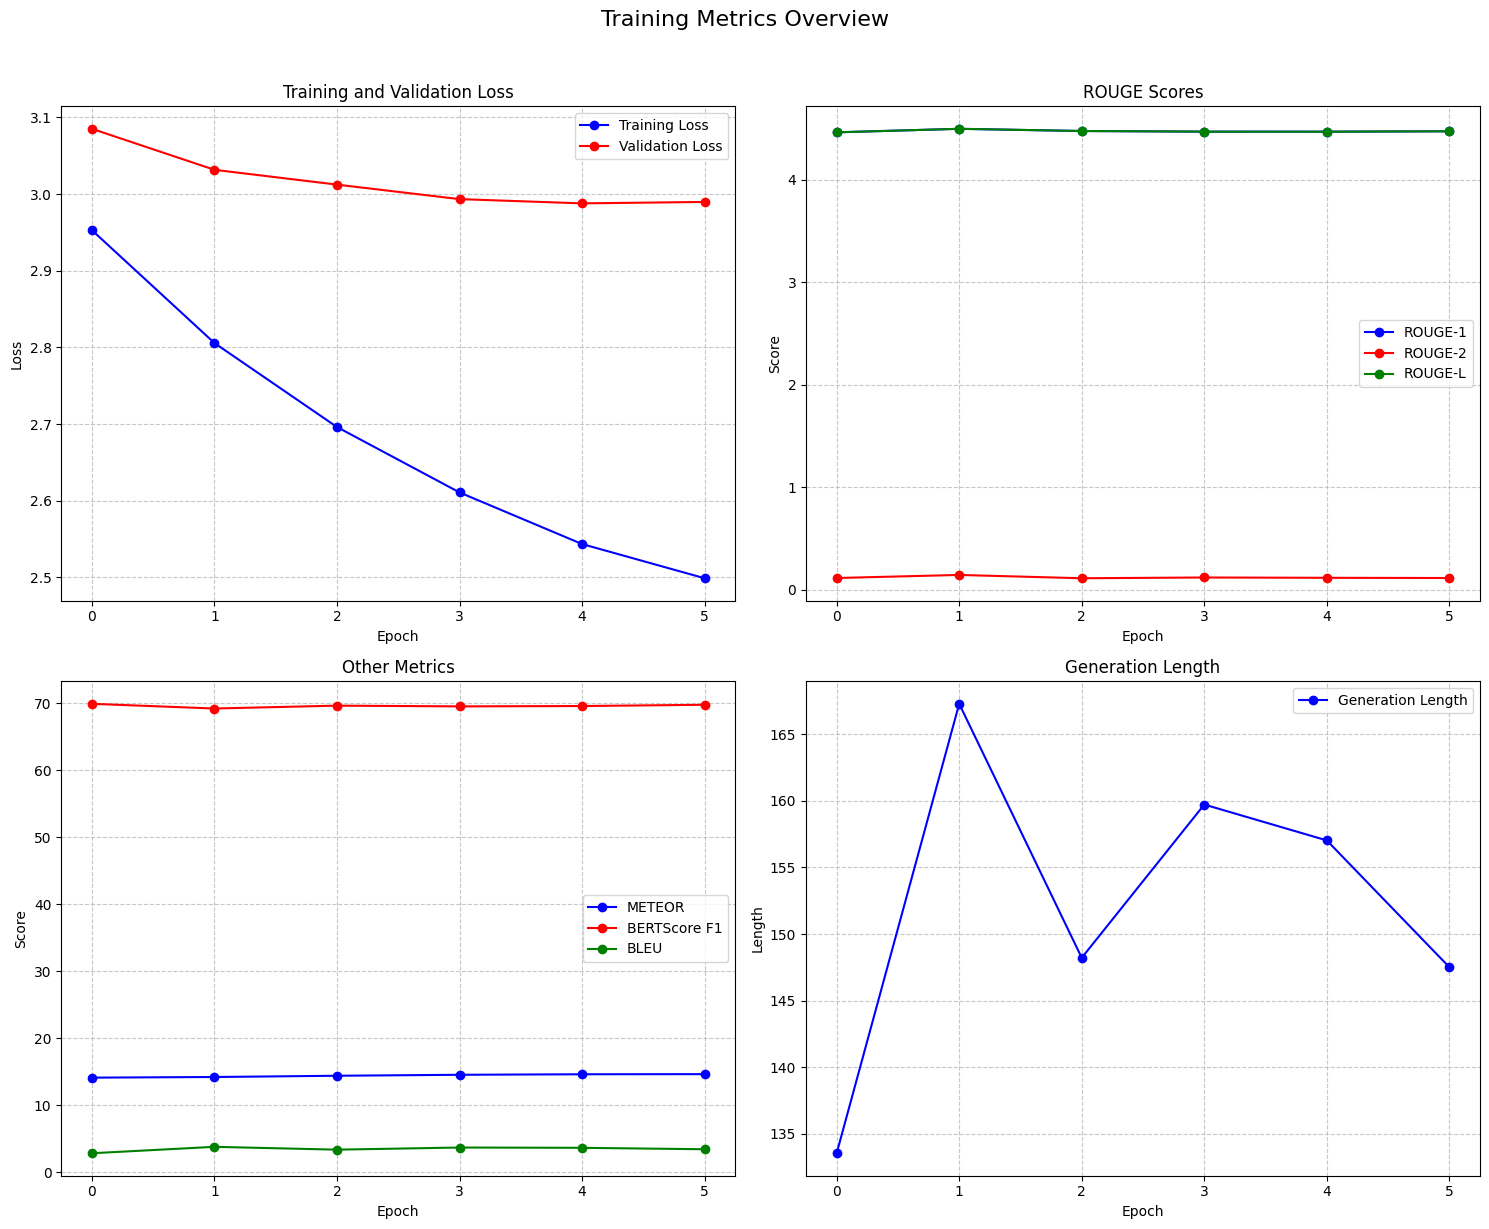


Final Metrics:
Train Loss: 2.4990
Validation Loss: 2.9897
ROUGE-1: 4.4745
ROUGE-2: 0.1142
ROUGE-L: 4.4745
METEOR: 14.6668
BERTScore: 69.7682
BLEU: 3.4636
Generation Length: 147.5087


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# nan 값을 제외하고 데이터 추출
train_loss = history_df['Training Loss'].dropna().values
eval_loss = history_df['Validation Loss'].dropna().values
rouge1 = history_df['Rouge1'].dropna().values
rouge2 = history_df['Rouge2'].dropna().values
rougeL = history_df['Rougel'].dropna().values
meteor = history_df['Meteor'].dropna().values
bertscore = history_df['Bertscore F1'].dropna().values
bleu = history_df['Bleu'].dropna().values
gen_len = history_df['Gen Len'].dropna().values

# 실제 데이터 개수에 맞춰 epochs 배열 생성
epochs = np.arange(len(eval_loss))

# 그래프 생성
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Training Metrics Overview', fontsize=16, y=1.02)

# Loss plot
ax1.plot(epochs, train_loss, 'b-', label='Training Loss', marker='o')
ax1.plot(epochs, eval_loss, 'r-', label='Validation Loss', marker='o')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# ROUGE scores over time
ax2.plot(epochs, rouge1, 'b-', label='ROUGE-1', marker='o')
ax2.plot(epochs, rouge2, 'r-', label='ROUGE-2', marker='o')
ax2.plot(epochs, rougeL, 'g-', label='ROUGE-L', marker='o')
ax2.set_title('ROUGE Scores')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Score')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

# Other metrics
ax3.plot(epochs, meteor, 'b-', label='METEOR', marker='o')
ax3.plot(epochs, bertscore, 'r-', label='BERTScore F1', marker='o')
ax3.plot(epochs, bleu, 'g-', label='BLEU', marker='o')
ax3.set_title('Other Metrics')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Score')
ax3.legend()
ax3.grid(True, linestyle='--', alpha=0.7)

# Generation length
ax4.plot(epochs, gen_len, 'b-', label='Generation Length', marker='o')
ax4.set_title('Generation Length')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Length')
ax4.legend()
ax4.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

# 그래프 저장
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# 최종 결과값들 출력
print("\nFinal Metrics:")
print(f"Train Loss: {train_loss[-1]:.4f}")
print(f"Validation Loss: {eval_loss[-1]:.4f}")
print(f"ROUGE-1: {rouge1[-1]:.4f}")
print(f"ROUGE-2: {rouge2[-1]:.4f}")
print(f"ROUGE-L: {rougeL[-1]:.4f}")
print(f"METEOR: {meteor[-1]:.4f}")
print(f"BERTScore: {bertscore[-1]:.4f}")
print(f"BLEU: {bleu[-1]:.4f}")
print(f"Generation Length: {gen_len[-1]:.4f}")